# Convolutional Network Benchmark

To obtain a benchmark for a basic convolutional network, we will create a simple network that informs us what to expect when using these networks. This will not contain any novel specializations, it is done to find a baseline which we can improve upon.

The architecture used here is inspired by the research in the form of the paper ['A Sensitivity Analysis of (and Practitioners’ Guide to) Convolutional Neural Networks for Sentence Classification'](https://arxiv.org/pdf/1510.03820.pdf), and is not complex.

While previous experiments have been done to find applicability of convolutional networks, this is the first to run it over a large set of data.

In [1]:
from exp8_feature_extraction import get_balanced_dataset
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.activations import relu, sigmoid

import matplotlib.pyplot as plt
import numpy as np
import gensim
import pickle
from seaborn import boxplot
from pandas import DataFrame

import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
all_reviews = get_balanced_dataset()

In [3]:
reviews_contents = [x.review_content for x in all_reviews]
labels = [1 if x.label else 0 for x in all_reviews]

In [5]:
max_review_words = 150
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(short_reviews)

short_sequences = []
short_labels = []
for i, sequence in enumerate(tokenizer.texts_to_sequences(reviews_contents)):
    if len(sequence) <= max_review_words:
        short_sequences.append(sequence)
        short_labels.append(labels[i])
        
word_sequences = np.array(pad_sequences(short_sequences))

In [9]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1

In [10]:
word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../../data/GoogleNews-vectors-negative300.bin",
                                                             binary=True)
embedding_length = word_vectors.vector_size

embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
for word, index in corpus_words.items():
  if word in word_vectors.vocab:
    embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

with open(embeddings_file_name, 'w') as outfile:
  json.dump(embedding_matrix.tolist(), outfile)

We add a quick check to make sure any modifications haven't caused our sequences and embedding matrix to misalign:

In [11]:
hello_wv = embedding_matrix[tokenizer.texts_to_sequences(["hello"])[0][0]]
assert hello_wv[0] > -0.055 and hello_wv[0] < -0.054
assert hello_wv[1] > 0.017 and hello_wv[1] < 0.018
assert hello_wv[2] > -0.006 and hello_wv[2] < -0.005

In [12]:
def to_vectorized_reviews(word_sequences, max_review_len, embedding_matrix):
    vectorized_reviews = np.zeros((len(word_sequences), max_review_len, embedding_matrix.shape[1], 1))
    for i, word_sequence in enumerate(word_sequences):
        for j, word in enumerate(word_sequence):
            for k, val in enumerate(embedding_matrix[word]):
                vectorized_reviews[i][j][k][0] = val
    return vectorized_reviews

We add quick tests for our vectorizing function:

In [13]:
test_embedding_matrix = np.array([[1, 2, 3], [3, 2, 1]])

actual_vectorized_reviews = to_vectorized_reviews([[0, 1]], 2, test_embedding_matrix)
assert np.array_equal(actual_vectorized_reviews, np.array([[[[1], [2], [3]], [[3], [2], [1]]]]))

actual_vectorized_reviews = to_vectorized_reviews([[1, 0]], 2, test_embedding_matrix)
assert np.array_equal(actual_vectorized_reviews, np.array([[[[3], [2], [1]], [[1], [2], [3]]]]))

In [14]:
vectorized_reviews = to_vectorized_reviews(word_sequences, len(word_sequences[0]), embedding_matrix)

I will separate some data, holding it until after I have finished tweaking the model. This is because tweaking the model towards the data I'm testing against is likely to cause a misrepresentation of how well the model performs. Using unseen data is better representative of future unseen data.

In [25]:
training_vectors = vectorized_reviews[:-10000]
training_labels = short_labels_2[:-10000]
held_vectors = vectorized_reviews[-10000:]
held_labels = short_labels_2[-10000:]

In [24]:
def get_conv_wv_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(10, 300),
          data_format="channels_last",
          input_shape=(max_review_words, 300, 1),
          activation=relu),
      tf.keras.layers.GlobalMaxPooling2D(data_format="channels_last"),
      Dropout(0.5),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

In [ ]:
conv_wv_scores = run_cross_validate(get_conv_wv_model, training_vectors, training_labels, cv=6, categorical=True)

In [29]:
print(conv_wv_scores)
print("Average accuracy:", sum(conv_wv_scores['accuracies'])/len(conv_wv_scores['accuracies']))

{'accuracies': [0.66613211939372, 0.6612177331746935, 0.6639077130029282, 0.6568368772311035, 0.654612240674634, 0.6592684567230587]}
Average accuracy: 0.6603291900333562


Convolutional networks perform significantly better than FFNNs and the results are not widely varying. This appears to be a confident benchmark for a simple convolutional network.

The distribution of results is as follows:

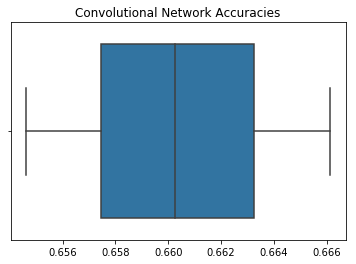

In [3]:
boxplot(DataFrame(conv_wv_scores)).set_title("Convolutional Network Accuracies")

plt.show()

Now let's try the model on unseen data:

In [26]:
from tensorflow.keras.callbacks import EarlyStopping
conv_model = get_conv_wv_model()
conv_model.fit(training_vectors, to_categorical(training_labels), epochs=12, batch_size=128, validation_split=0.3,
               callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

Train on 81186 samples, validate on 34794 samples
Epoch 1/12
81186/81186 [==============================] - 137s 2ms/step - loss: 0.6485 - acc: 0.6256 - val_loss: 0.6260 - val_acc: 0.6526
Epoch 2/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.6242 - acc: 0.6541 - val_loss: 0.6272 - val_acc: 0.6517
Epoch 3/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.6081 - acc: 0.6727 - val_loss: 0.6189 - val_acc: 0.6581
Epoch 4/12
81186/81186 [==============================] - 135s 2ms/step - loss: 0.5940 - acc: 0.6828 - val_loss: 0.6121 - val_acc: 0.6670
Epoch 5/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5795 - acc: 0.6974 - val_loss: 0.6121 - val_acc: 0.6675
Epoch 6/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5644 - acc: 0.7110 - val_loss: 0.6200 - val_acc: 0.6597
Epoch 7/12
81186/81186 [==============================] - 136s 2ms/step - loss: 0.5502 - acc: 0.7193 - val_loss: 0.6173 - 

In [34]:
categorical_labels = to_categorical(held_labels)

In [35]:
conv_model.evaluate(held_vectors, categorical_labels)[1]

10000/10000 [==============================] - 6s 609us/step


0.6657

In [37]:
auc_metric = tf.metrics.auc(categorical_labels, conv_model.predict(held_vectors))

In [41]:
auc, update_op = auc_metric
with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("tf auc: {}".format(sess.run([auc, update_op])))

tf auc: [9999999000.0, 0.72368735]


The model performs very similarly on the unseen data as the data used to create the model. There was not a lot of tweaking, so it is not unreasonable that this should occur. If this can be maintained then this model could do well with slight changes in the domain, something very easy to do with product and service reviews.